# *Price Prediction*

### _Importing Modules_

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from decimal import Decimal
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM,Flatten
from sklearn.metrics import mean_squared_error
import math

from datetime import timedelta

### _Loading the Dataset_

In [2]:
data = pd.read_csv('avocado.csv')

In [3]:
data.drop('Unnamed: 0',axis =1,inplace =True)
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values(by=['Date'],inplace=True)       # Sorting the data by the dates

data = data.reset_index().drop('index',axis=1)

## *Predicting The Next 30 Days Average Price Of Avocados*

### - About Time Series Forecasting and Long-Short Term Memory:

###   *Time Series Forecasting* :
        
#### - *What is it* ?
    - By using the information of historical values and related trends to predict the future patterns.
    
#### - *Why this method* ?
    - In the 3 years of time intervals, the mean and the variance of the average Price remained constant(Stationarity).Furthermore,           the seasonality factor has an impact on the average price(e.g The average price in every year fall have  higher price than the           other seasons.
       
#### - *How I use this method* ?
    - In this project, I have considered 100 historical data of a certain date to predict future activities. I chose 100 days of historical data as the price alters more by seasons(every 3~4months),therefore, I think that it is more accurate to consider around 3 months of data instead of 1 or 2 months.
    
#### - *Why LSTM* ?
    - LSTM is one of the most suitable method of making predictions based on the time-series data.LSTM can learn which data sequence is crucial to keep or forget. Due to it's special factor of keeping the relevant information, it is a suitable model to use  in order to predict the future price.
            

### *Scaling The Dataset*


- By using the MinMaxScaler, we scale the dataset from (0,1).
- This step is important since LSTM model is sensitive to the scale of the data.

In [4]:
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [5]:
price_set = data['AveragePrice']
price_set = scaler.fit_transform(np.array(price_set).reshape(-1,1))
price_set

array([[0.46619217],
       [0.37366548],
       [0.44128114],
       ...,
       [0.34875445],
       [0.44839858],
       [0.3202847 ]])

###  *Separating  The Dataset* 

        - Separated into 80% as train sets and 20% as test sets

In [6]:
train_set = price_set[0:14600,:]    # 80% of dataset as train set
train_set

array([[0.46619217],
       [0.37366548],
       [0.44128114],
       ...,
       [0.39145907],
       [0.47686833],
       [0.4341637 ]])

In [7]:
test_set = price_set[14601:,:]      # 20% of dataset
test_set

array([[0.42348754],
       [0.36654804],
       [0.46263345],
       ...,
       [0.34875445],
       [0.44839858],
       [0.3202847 ]])

In [8]:

def into_dataset(dataset,time_step=1):
    X,y = [],[]
    for i in range(len(dataset)-1-time_step):   # looking at 100 values before the current values
        
        data = dataset[i:(i+time_step),0]          # Taking 100 datas per iteration
        X.append(data)
        y.append(dataset[i+time_step,0])           # Take every 100,101,102,103,...
    return np.array(X),np.array(y)

- In the X dataset, I have added 100 historical data(Time-steps) into each array
- In the y dataset, I have added every data from the 100th day.

In [9]:
time_step = 100
X_train,y_train = into_dataset(train_set,time_step)
X_test,y_test = into_dataset(test_set,time_step)

In [10]:
# Reshaping X
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

- I have reshaped the X dataset from 2D to 3D since LSTM only accepts 3D input shape(batch_size,time-steps,sequence-lengths)

## _Constructing the LSTM Modules_

In [11]:
X_train.shape

(14499, 100, 1)

In [12]:
input_no = [16,32,64,128]

### _Choosing the optimal number of units_

- By running a for loop with several different numbers of units, we will choose the optimal value which gives out the lowest root mean squared errors.

In [13]:

for i in input_no:
    model_ts = Sequential()
    model_ts.add(LSTM(i,input_shape=X_train.shape[1:],return_sequences=True))
    model_ts.add(Dropout(0.2))
    
    model_ts.add(LSTM(i,return_sequences=True))
    model_ts.add(Dropout(0.2))
    
    model_ts.add(LSTM(i,return_sequences=True))
    model_ts.add(Dropout(0.2))
    
    model_ts.add(Flatten())
    
    model_ts.add(Dense(1))
    
    model_ts.compile(loss='mean_squared_error',optimizer='adam')
    
    model_ts.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=1,batch_size=64)
    
    pred = model_ts.predict(X_test)
 
    mse_train = math.sqrt(mean_squared_error(y_test,pred))
    print(mse_train)

Train on 14499 samples, validate on 3547 samples
14499/14499 [==============================] - 65s 4ms/sample - loss: 0.0214 - val_loss: 0.0151
0.12305621148308317
Train on 14499 samples, validate on 3547 samples
14499/14499 [==============================] - 73s 5ms/sample - loss: 0.0209 - val_loss: 0.0151
0.12272002613762975
Train on 14499 samples, validate on 3547 samples
14499/14499 [==============================] - 86s 6ms/sample - loss: 0.0210 - val_loss: 0.0155
0.12441862172660928
Train on 14499 samples, validate on 3547 samples
14499/14499 [==============================] - 119s 8ms/sample - loss: 0.0207 - val_loss: 0.0164
0.12808786807648034


- I will use 32 units as it had the lowest RMSE.

### *LSTM Model With Optimal Number of Units*

In [14]:
model_ts = Sequential()
model_ts.add(LSTM(32,input_shape=X_train.shape[1:],return_sequences=True))
model_ts.add(Dropout(0.2))

- Created LSTM model with 32 units.
- Input shape => (None,100,1). In order to have the flexibility to feed any batch size at the time of fitting the data to the model, I 
set it as None.
- Return_sequences = True => Access the hidden state output for each input time step. By using this, it can maintain 3D sequences input on the next LSTM sequence.
- Dropout is used in order to reduce overfitting of the model from regularization.

In [15]:
model_ts.add(LSTM(32,return_sequences=True))
model_ts.add(Dropout(0.2))

In [16]:
model_ts.add(LSTM(32,return_sequences=True))
model_ts.add(Dropout(0.2))

In [17]:
model_ts.add(Flatten())

- Flatten makes the x-Dimensional layer into 1-Dimensional
- Before adding 1 Dense layer , we need to flatten the layer since without flatten the layers, it will have different shape with the target array(2D).

In [18]:
model_ts.add(Dense(1))

In [19]:
model_ts.compile(loss='mean_squared_error',optimizer='adam')

In [20]:
model_ts.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 100, 32)           4352      
_________________________________________________________________
dropout_12 (Dropout)         (None, 100, 32)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 100, 32)           8320      
_________________________________________________________________
dropout_13 (Dropout)         (None, 100, 32)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 100, 32)           8320      
_________________________________________________________________
dropout_14 (Dropout)         (None, 100, 32)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3200)             

In [21]:
model_ts.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=30,batch_size=64)

Train on 14499 samples, validate on 3547 samples
Epoch 1/30
14499/14499 [==============================] - 81s 6ms/sample - loss: 0.0203 - val_loss: 0.0150
Epoch 2/30
14499/14499 [==============================] - 83s 6ms/sample - loss: 0.0194 - val_loss: 0.0151
Epoch 3/30
14499/14499 [==============================] - 78s 5ms/sample - loss: 0.0195 - val_loss: 0.0153
Epoch 4/30
14499/14499 [==============================] - 78s 5ms/sample - loss: 0.0192 - val_loss: 0.0150
Epoch 5/30
14499/14499 [==============================] - 72s 5ms/sample - loss: 0.0195 - val_loss: 0.0150
Epoch 6/30
14499/14499 [==============================] - 75s 5ms/sample - loss: 0.0193 - val_loss: 0.0163
Epoch 7/30
14499/14499 [==============================] - 73s 5ms/sample - loss: 0.0192 - val_loss: 0.0149
Epoch 8/30
14499/14499 [==============================] - 80s 6ms/sample - loss: 0.0191 - val_loss: 0.0152
Epoch 9/30
14499/14499 [==============================] - 84s 6ms/sample - loss: 0.0192 - val_l

In [22]:
test_pred = model_ts.predict(X_test)


mse_test = math.sqrt(mean_squared_error(y_test,test_pred))
print("The RMSE of the testing sets is {0:.6f}".format(mse_test))

The RMSE of the testing sets is 0.125738


- The RMSE testing sets are in the range between(0.1 to 0.5). We can tell that the model is relatively accurate.

## *Predicting the Price For The Next 30 Days*

In [23]:
X_input = test_set[3548:].reshape(1,-1)  #100 days of data

- Taking previous 100 data of the 1st day I will make prediction on.

In [24]:
inputs= list(X_input)
inputs= inputs[0].tolist()
len(inputs)

100

- Making a temporary input list to save the original X_input

In [25]:
# Prediction for next 10 days
res = []
time_step = 100

for i in range(30):
    if (len(inputs) <= 100):    # prediction for the first day of the next 30 days
        X_input = X_input.reshape((1,time_step,1))
        pred = model_ts.predict(X_input,verbose=0)         # Predicted the 1st day of the 30 days with 100 days sample of X_input
        inputs.extend(pred[0].tolist())      # Append the predicted value into temp list
        res.extend(pred.tolist())         # list which saves the predicted values(30days)

    else:
        X_input = np.array(inputs[1:])        # Keeping the array size as 100 by moving to next value by 1
        X_input = X_input.reshape((1,time_step,1))
        pred = model_ts.predict(X_input,verbose=0)    
        inputs.extend(pred[0].tolist())       # This step is required since the new predicted day will be considered for the next day
        inputs= inputs[1:]                    # Advancing the data
        res.extend(pred.tolist())


- For the 1st prediction, I will add the predicted value to the temporary list(inputs) and res (saves all the 30 days of predicted values).
- Since we are only considering the 100 previous data, now the 1st predicted value will also be considered in the 100 data for the 2nd day. Therefore, I have shifted the array to the right by 1 for the input of the 2nd day. And for the next days until the 30th, I kept on shifting the input array to the right by 1 in order to just take the 100 data.

## _Visualizing The Predicted Values In The Graph_

In [26]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

In [27]:
dt = scaler.fit_transform(pd.DataFrame(data['AveragePrice']))
df = dt.tolist()
print(len(df))

#df.extend(lst_output)    # Combining previous data with future 30 days data
#print(len(df))

18249


### _Average Price Graph of The Latest 100 Days (Including The Predicted Values)_

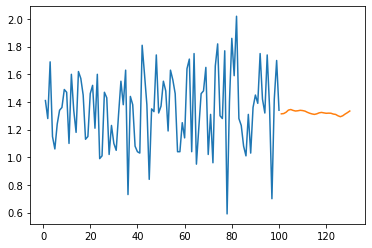

In [28]:
#Last 100 days
plt.figure('Lineplot On The Last 100 Days(Including The Predicted Values)')
plt.plot(day_new,scaler.inverse_transform(df[18149:]))
plt.plot(day_pred,scaler.inverse_transform(res))

In [29]:
df.extend(res)    # Combining previous data with future 30 days data
print(len(df))


18279


### _Adding 30 More days To The Original Dates_

In [30]:

extra_dates = data['Date'][18219:]
extra_dates = pd.DataFrame(extra_dates).reset_index().drop('index',axis=1)

for i in range(1,31):
    extra_dates.iloc[i-1] = extra_dates.iloc[i-1]+timedelta(days=i)    
dates = pd.DataFrame(data['Date'])
new_dates = dates.append(extra_dates)
new_dates = new_dates.reset_index().drop('index',axis=1)
new_dates

,Date
0,2015-01-04
1,2015-01-04
2,2015-01-04
3,2015-01-04
4,2015-01-04
...,...
18274,2018-04-20
18275,2018-04-21
18276,2018-04-22
18277,2018-04-23


In [31]:
df = scaler.inverse_transform(df)
df = pd.DataFrame(df,columns=['Price'])
df

,Price
0,1.750000
1,1.490000
2,1.680000
3,1.520000
4,1.640000
...,...
18274,1.293292
18275,1.299885
18276,1.312178
18277,1.322605


## *Plotting The Graphs With The Predicted Values*

Text(0.5, 1.0, 'Before The Prediction')

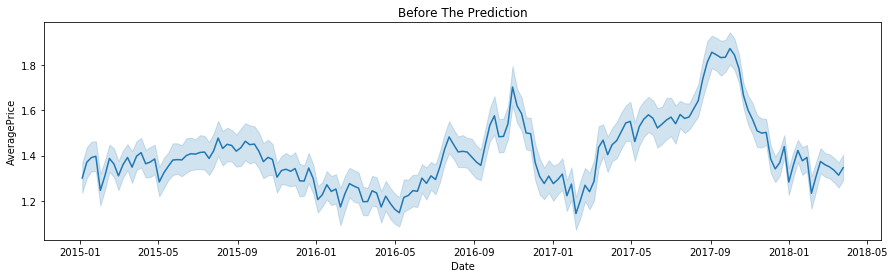

In [32]:
plt.figure(figsize=(15,4))

sns.lineplot(data['Date'],data['AveragePrice']).set_title('Before The Prediction')

Text(0.5, 1.0, 'With The Prediction of 30 Days')

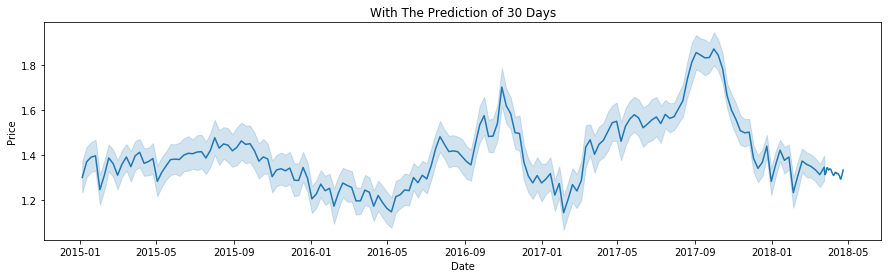

In [33]:
plt.figure(figsize=(15,4))
sns.lineplot(new_dates['Date'],df['Price']).set_title('With The Prediction of 30 Days')

### _Graph Of The Predicted Price_

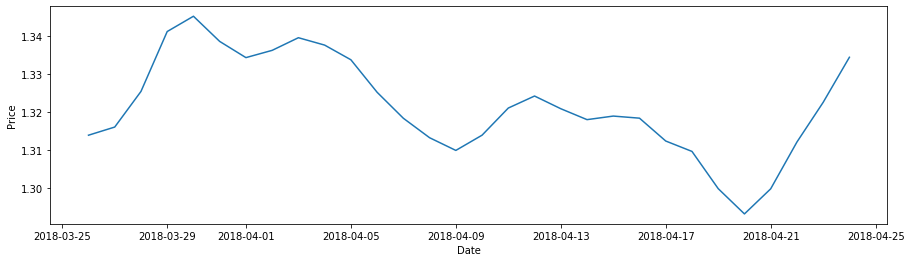

In [34]:
plt.figure(figsize=(15,4))
sns.lineplot(new_dates['Date'].tail(30),df['Price'].tail(30))

- Overall, the price had risen by approximately 0.015 dollars over a month. There was a fluctuation in the price during this one month. The price increased significantly for the first week. Then, the price dwindled steadily until 2018-04-20 and reached the bottom price of that month. Once it reached the bottom price, the price increased rapidly in the last week and reached a final price of approximately $ 1.33. This prediction can be reasonable as the average price increased from march to april in 2015 and 2017.